In [24]:
import pandas as pd
import os
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
os.chdir('/Users/microwave/AIO_2024/Module_3/Project/Sentiment_analysis/data')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/microwave/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/microwave/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/microwave/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [25]:
df = pd.read_csv('IMDB Dataset.csv')
df = df.drop_duplicates()

# Preprocessing data

In [26]:
stop = set(stopwords.words('english'))

def expand_contractions(text):
    return contractions.fix(text)

def preprocess_text(text):
    wl = WordNetLemmatizer()
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = expand_contractions(text)


    emoji_clean = re.compile("["
                             "\U0001F600-\U0001F64F"  # emoticons
                             "\U0001F300-\U0001F5FF"  # symbols & pictographs
                             "\U0001F680-\U0001F6FF"  # transport & map symbols
                             "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             "\U00002702-\U000027B0"
                             "\U000024C2-\U0001F251"
                             "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)

    text = re.sub(r'\.(?=\S)', '. ', text)
    text = re.sub(r'http\S+', '', text)
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    text = ' '.join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()])

    return text

df['review'] = df['review'].apply(preprocess_text)

/Users/microwave/opt/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


# EDA data

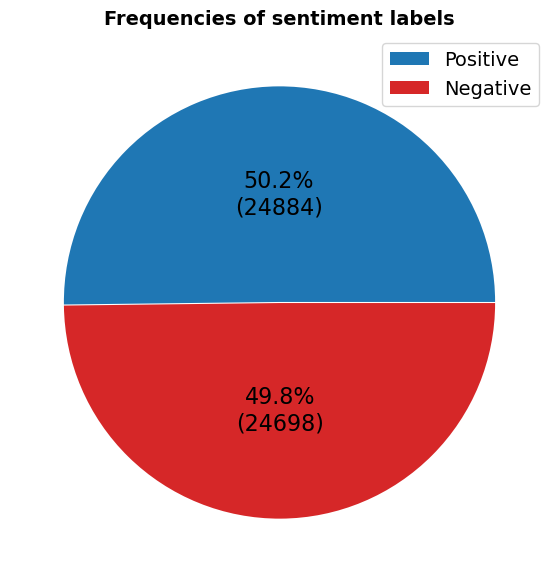

In [27]:
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]
labels = ['positive', 'negative']

fig, ax = plt.subplots(figsize=(11, 7))
ax.pie(
    x=data,
    autopct=lambda pct: func(pct, data),  
    explode=[0.0025, 0.0025],  
    pctdistance=0.5,  
    colors=[sns.color_palette()[0], 'tab:red'],  
    textprops={'fontsize': 16}  
)


plt.title('Frequencies of sentiment labels', fontsize=14, fontweight='bold')
plt.legend(labels=['Positive', 'Negative'], loc="best", prop={'size': 14})
plt.savefig("PieChart.png")
plt.show()

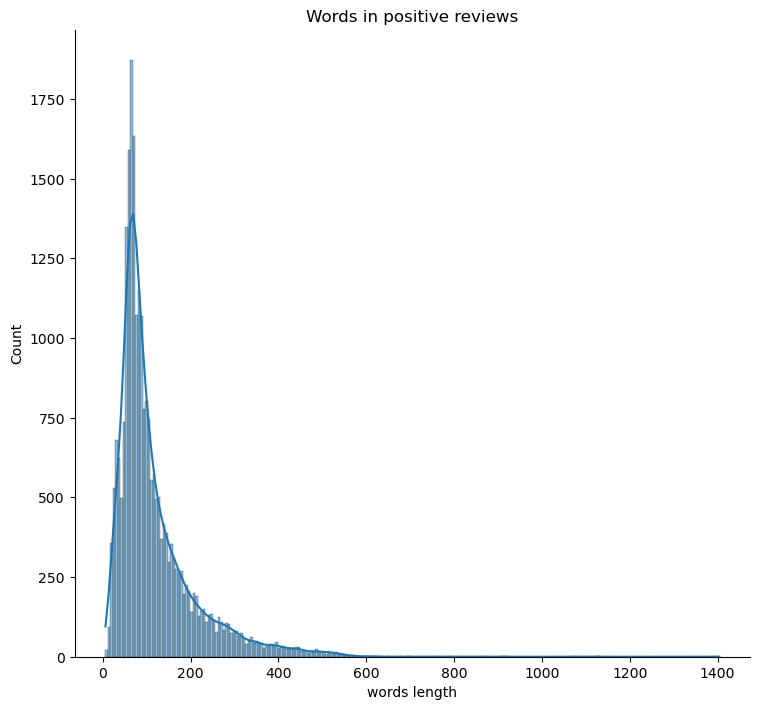

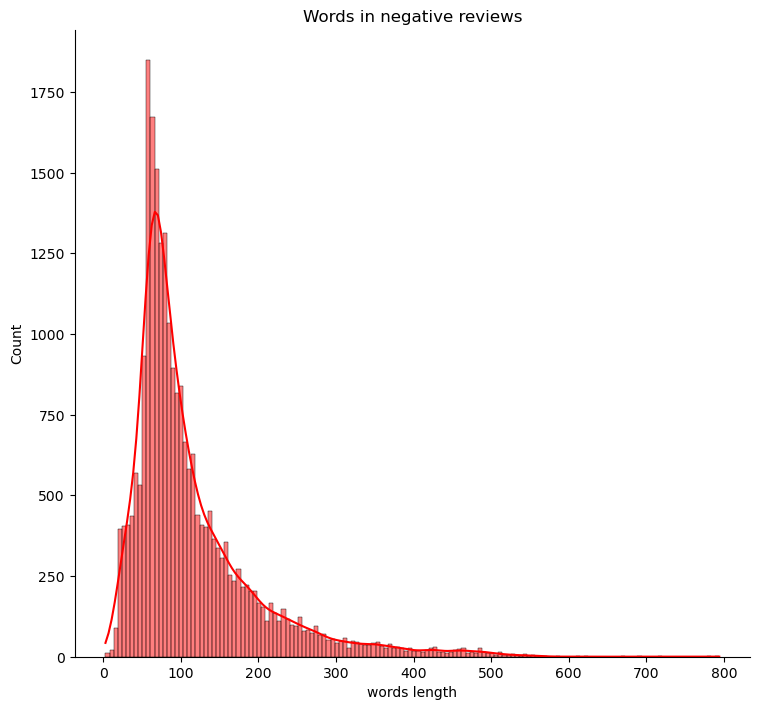

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

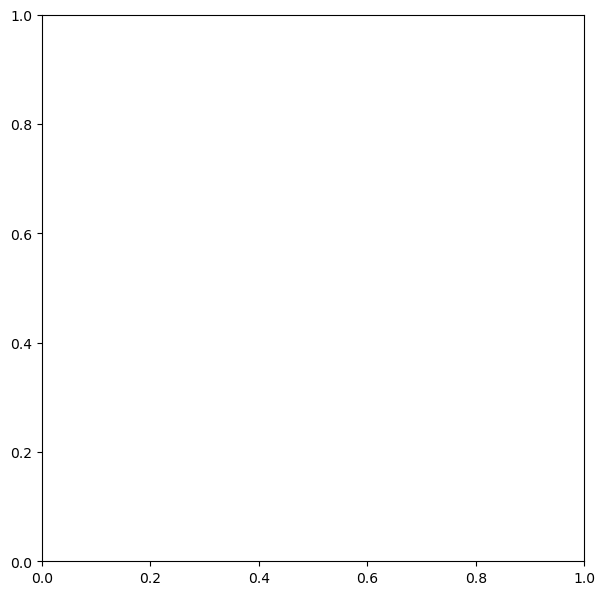

In [28]:
words_len = df['review'].str.split().map(lambda x: len(x))

df_temp = df.copy()
df_temp['words length'] = words_len

hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False
).set(title='Words in positive reviews')
plt.show(hist_positive)

hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False, palette=['red']
).set(title='Words in negative reviews')
plt.show(hist_negative)

# Train test split

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Encode sentiment labels
label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    df['review'], y_data, test_size=0.2, random_state=42
)


In [32]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train,y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
)


dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
print("Decision Tree Accuracy:", accuracy_score(y_pred, y_test))

rf_classifier = RandomForestClassifier(
    random_state=42
)

rf_classifier.fit(x_train_encoded, y_train)

y_pred_rf = rf_classifier.predict(x_test_encoded)
print("Random Forest Accuracy:", accuracy_score(y_pred_rf, y_test))


Decision Tree Accuracy: 0.7180598971463145
Random Forest Accuracy: 0.8427952001613391
